# Hands-on time

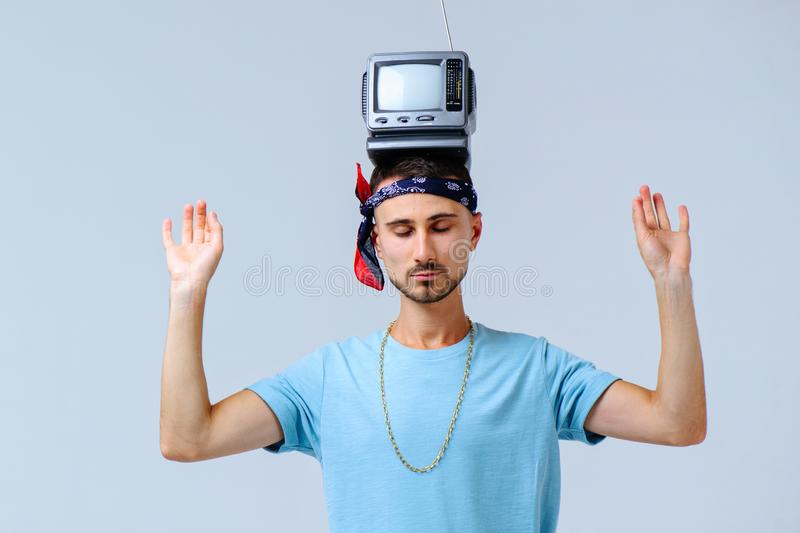

In this lab we'll follow the next steps:
1. Downnload data using Yahoo Finance API
2. Explore and analyze data
3. Learn how to deal with forecasting models - Prophet

In [29]:
# *IMPORT LIBRARIES USED*

#!pip install prophet
#!pip install yfinance

from prophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

**yfinance**

"Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

yfinance aimes to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance."

https://pypi.org/project/yfinance/

# 1. Download data

Definition of an analysis starting and ending period

In [30]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [31]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [191]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [179]:
forex_df

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-01,1.438994,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473
2010-01-04,1.442398,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492
2010-01-05,1.436596,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826
2010-01-06,1.440403,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471
2010-01-07,1.431803,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768
...,...,...,...,...,...,...,...
2024-05-29,1.085187,1.275836,0.91229,157.261993,170.654007,1.36460,0.664800
2024-05-30,1.080182,1.269799,0.91280,157.608002,170.216003,1.37170,0.661370
2024-05-31,1.083541,1.273042,0.90331,156.953003,169.996002,1.36833,0.663030


# 2. Data exploration

### Check missing values and fill if needed

In [34]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2011-04-15,1.443210,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-27,1.309278,1.568209,NaN,77.459999,101.421997,1.0024,1.061582
2012-01-31,1.313957,1.570845,NaN,76.360001,100.330002,1.0024,1.058604
2012-12-04,NaN,1.609787,NaN,82.133003,107.301003,NaN,NaN
2013-10-08,NaN,NaN,NaN,NaN,131.289993,NaN,NaN
2019-05-22,NaN,NaN,NaN,NaN,123.438004,NaN,NaN


Multiple strategies can be used to fill missing values, these depend on the nature of the problem (but be aware of the consequences):

- use median, mode, mean values
- use a statistical method: regression, nearest neighbors
- back/forward fill, **interpolate**
- drop missing data

In [35]:
# fillna fills with given value or method: in this case forward fill
forex_df.fillna(method='ffill', axis=0).loc['2011-04-15']

C:\Users\Julia\AppData\Local\Temp\ipykernel_11856\2608840311.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



eurusd_close      1.443210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-15 00:00:00, dtype: float64

In [36]:
forex_df.loc['2011-04-14']

eurusd_close      1.444210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-14 00:00:00, dtype: float64

In [37]:
# interpolate interpolates given a method
forex_df.interpolate(method='linear', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.629145
usdchf_close      0.894250
usdjpy_close     83.465000
eurjpy_close    120.417999
usdcad_close      0.961300
audusd_close      1.053002
Name: 2011-04-15 00:00:00, dtype: float64

In [38]:
forex_df.loc[['2011-04-14', '2011-04-15', '2011-04-18']]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2011-04-14,1.444210,1.626889,0.8959,83.782997,121.000000,0.9626,1.049803
2011-04-15,1.443210,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-18,1.441296,1.631401,0.8926,83.147003,119.835999,0.9600,1.056201


In [39]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,


In [40]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3761 entries, 2010-01-01 to 2024-06-04
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3761 non-null   float64
 1   gbpusd_close  3761 non-null   float64
 2   usdchf_close  3761 non-null   float64
 3   usdjpy_close  3761 non-null   float64
 4   eurjpy_close  3761 non-null   float64
 5   usdcad_close  3761 non-null   float64
 6   audusd_close  3761 non-null   float64
dtypes: float64(7)
memory usage: 364.1 KB


In [41]:
forex_df.describe()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
count,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000
mean,1.194515,1.415090,0.949510,108.487053,127.902548,1.213065,0.807412
std,0.114131,0.152315,0.051313,18.639837,14.307215,0.140534,0.131488
min,0.959619,1.072754,0.722800,75.739998,94.209999,0.943200,0.574290
25%,1.101868,1.280082,0.913910,98.940002,119.508003,1.049090,0.708818
50%,1.164890,1.380567,0.949790,108.893997,128.348999,1.273080,0.759400
75%,1.298802,1.561695,0.984500,115.530998,135.606003,1.326800,0.920895
max,1.484406,1.716090,1.162700,158.223999,170.654007,1.457800,1.103497


### Visualize data

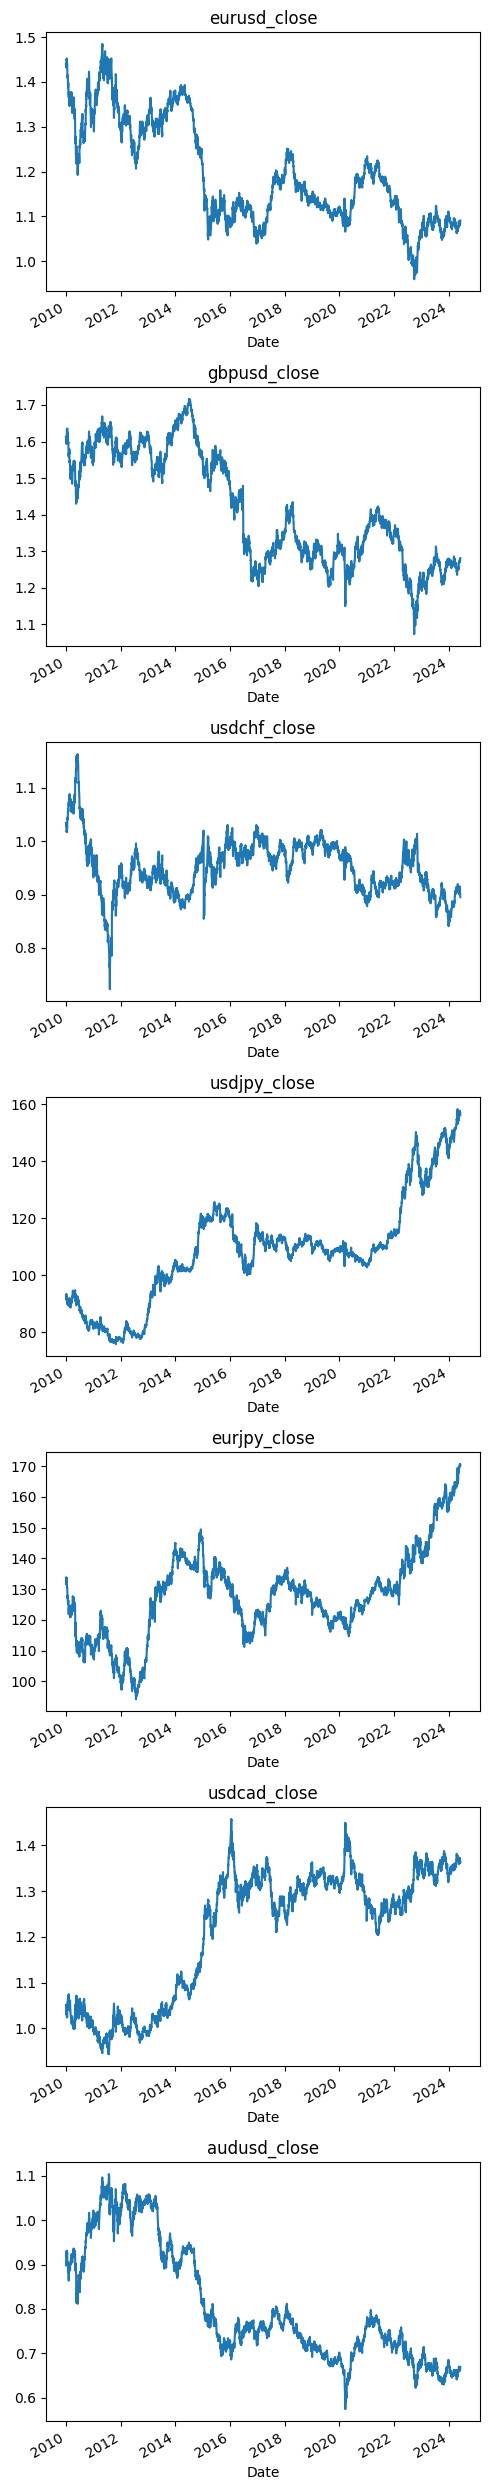

In [42]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [43]:
# Looking for something fancier? go for plotly :-)

for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Scaling the changes using by percentange change, in order to remove differences between pricing, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate. (e.g. for VaR analysis)

In [44]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [45]:
# New Dataframe cleaned
forex_rate_df_clean

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-04,0.002366,-0.001192,-0.004643,-0.004574,-0.002393,-0.009703,0.015604
2010-01-05,-0.004022,-0.007628,0.004470,-0.009838,-0.013944,-0.001441,-0.000729
2010-01-06,0.002650,0.002067,-0.005901,0.008418,0.011275,-0.007311,0.009481
2010-01-07,-0.005971,-0.005609,0.005839,0.011196,0.005526,0.002035,-0.002937
2010-01-08,0.006499,0.005657,-0.009675,-0.007817,-0.001929,-0.004062,0.007956
...,...,...,...,...,...,...,...
2024-05-29,-0.000922,-0.001097,-0.000997,0.002659,0.001802,0.001255,-0.001145
2024-05-30,-0.004612,-0.004731,0.000559,0.002200,-0.002567,0.005203,-0.005159
2024-05-31,0.003110,0.002554,-0.010397,-0.004156,-0.001292,-0.002457,0.002510


Aggregated Returns plot

In [46]:
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line

# Show plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Standard Deviation of the different rates of returns.

In [47]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns,
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Correlation analysis between numerical variables.

In [48]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000,
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Pearson Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

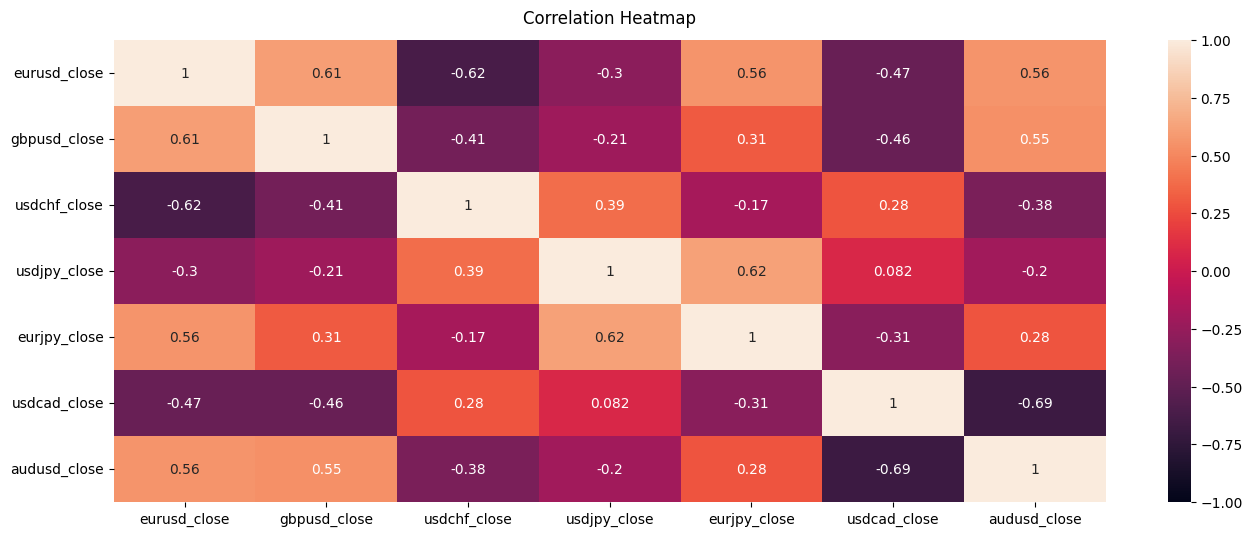

In [49]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 3. Forecasting Method - Prophet

Prophet is a library developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [171]:
forex_df

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2009-11-30,1.438994,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473,2010-01-01,1.438994
2009-12-01,1.442398,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492,2010-01-04,1.442398
2009-12-02,1.436596,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826,2010-01-05,1.436596
2009-12-03,1.440403,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471,2010-01-06,1.440403
2009-12-04,1.431803,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768,2010-01-07,1.431803
...,...,...,...,...,...,...,...,...,...
2024-04-25,1.085187,1.275836,0.91229,157.261993,170.654007,1.36460,0.664800,2024-05-29,1.085187
2024-04-26,1.080182,1.269799,0.91280,157.608002,170.216003,1.37170,0.661370,2024-05-30,1.080182
2024-04-29,1.083541,1.273042,0.90331,156.953003,169.996002,1.36833,0.663030,2024-05-31,1.083541


In [51]:
# In order to forecast the series we need to: 1.
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2024-05-29,1.085187,1.275836,0.91229,157.261993,170.654007,1.36460,0.664800,2024-05-29,1.085187
2024-05-30,1.080182,1.269799,0.91280,157.608002,170.216003,1.37170,0.661370,2024-05-30,1.080182
2024-05-31,1.083541,1.273042,0.90331,156.953003,169.996002,1.36833,0.663030,2024-05-31,1.083541
2024-06-03,1.085305,1.274372,0.90132,157.179993,170.580002,1.36189,0.665690,2024-06-03,1.085305
2024-06-04,1.090739,1.281017,0.89502,156.076004,170.227997,1.36287,0.669008,2024-06-04,1.090739


Create train and test, test used in prophet only for backtesting reason!

In [52]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-06-10']

In [53]:
# create train and test dataset
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]


In [54]:
train

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2010-01-04,1.442398,1.611370,1.029100,92.495003,133.389999,1.04100,0.912492,2010-01-04,1.442398
2010-01-05,1.436596,1.599079,1.033700,91.584999,131.529999,1.03950,0.911826,2010-01-05,1.436596
2010-01-06,1.440403,1.602384,1.027600,92.356003,133.013000,1.03190,0.920471,2010-01-06,1.440403
2010-01-07,1.431803,1.593397,1.033600,93.389999,133.748001,1.03400,0.917768,2010-01-07,1.431803
2010-01-08,1.441109,1.602410,1.023600,92.660004,133.490005,1.02980,0.925069,2010-01-08,1.441109
...,...,...,...,...,...,...,...,...,...
2020-10-26,1.184848,1.305466,0.904560,104.682999,124.035004,1.31472,0.713201,2020-10-26,1.184848
2020-10-27,1.180944,1.301575,0.907900,104.832001,123.796997,1.32061,0.711710,2020-10-27,1.180944
2020-10-28,1.178411,1.303186,0.908875,104.544998,123.169998,1.31918,0.712310,2020-10-28,1.178411


In [55]:
m = Prophet()
m.fit(train[['ds', 'y']])

12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future = m.make_future_dataframe(20, freq='B')

In [57]:
future

,ds
0,2010-01-04
1,2010-01-05
2,2010-01-06
3,2010-01-07
4,2010-01-08
...,...
2838,2020-11-23
2839,2020-11-24
2840,2020-11-25
2841,2020-11-26


In [58]:
future = m.make_future_dataframe(20, freq='B') # Explain B with https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
forecast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

In [59]:
forecast_results

,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-02,1.133779,1.103983,1.164721
2020-11-03,1.132473,1.102289,1.161301
2020-11-04,1.131134,1.102227,1.161776
2020-11-05,1.129762,1.101223,1.159002
2020-11-06,1.128462,1.098653,1.157374
2020-11-09,1.124149,1.095079,1.152012
2020-11-10,1.122858,1.093621,1.153543
2020-11-11,1.121629,1.091821,1.150327
2020-11-12,1.120461,1.091736,1.149471


In [60]:
final_df_results = pd.merge(test[['eurusd_close']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [61]:
final_df_results

,eurusd_close,yhat
2020-11-02,1.164212,1.133779
2020-11-03,1.164280,1.132473
2020-11-04,1.176221,1.131134
2020-11-05,1.173268,1.129762
2020-11-06,1.181754,1.128462
2020-11-09,1.189301,1.124149
2020-11-10,1.182732,1.122858
2020-11-11,1.181879,1.121629
2020-11-12,1.178030,1.120461
2020-11-13,1.180339,1.119455


## Model evaluation and scores

In [62]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae https://en.wikipedia.org/wiki/Mean_absolute_error
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse https://en.wikipedia.org/wiki/Root-mean-square_deviation
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias https://en.wikipedia.org/wiki/Bias_(statistics)
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


Mean MAE: 0.06
MAE%: 5.22%
RMSE: 0.06
Bias: -0.06

5th percetile MAE: 0.03
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.08


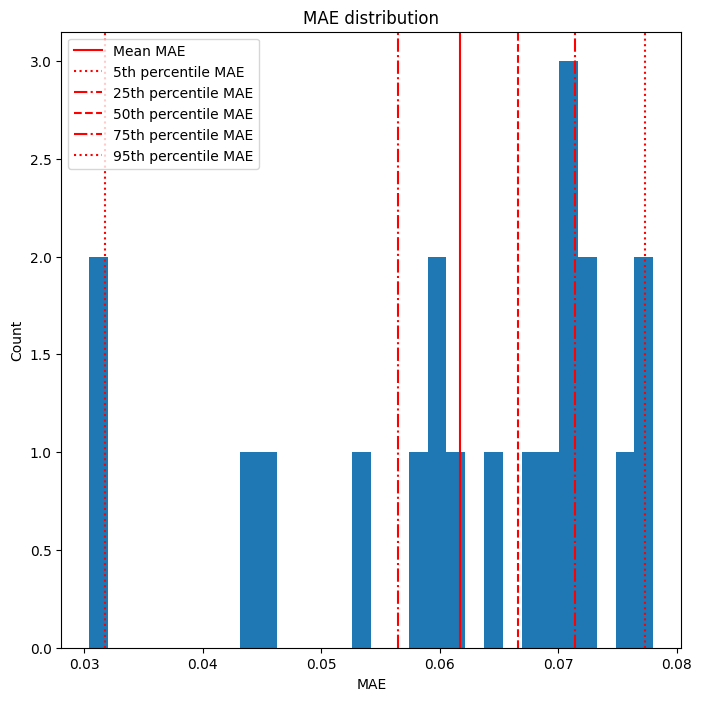

In [63]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)


d:\Studies\Materials\Second-cycle\I year\III trimester\Ammagamma-Lab\ammagamma-lab\ag-lab\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\Studies\Materials\Second-cycle\I year\III trimester\Ammagamma-Lab\ammagamma-lab\ag-lab\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\Studies\Materials\Second-cycle\I year\III trimester\Ammagamma-Lab\ammagamma-lab\ag-lab\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series c

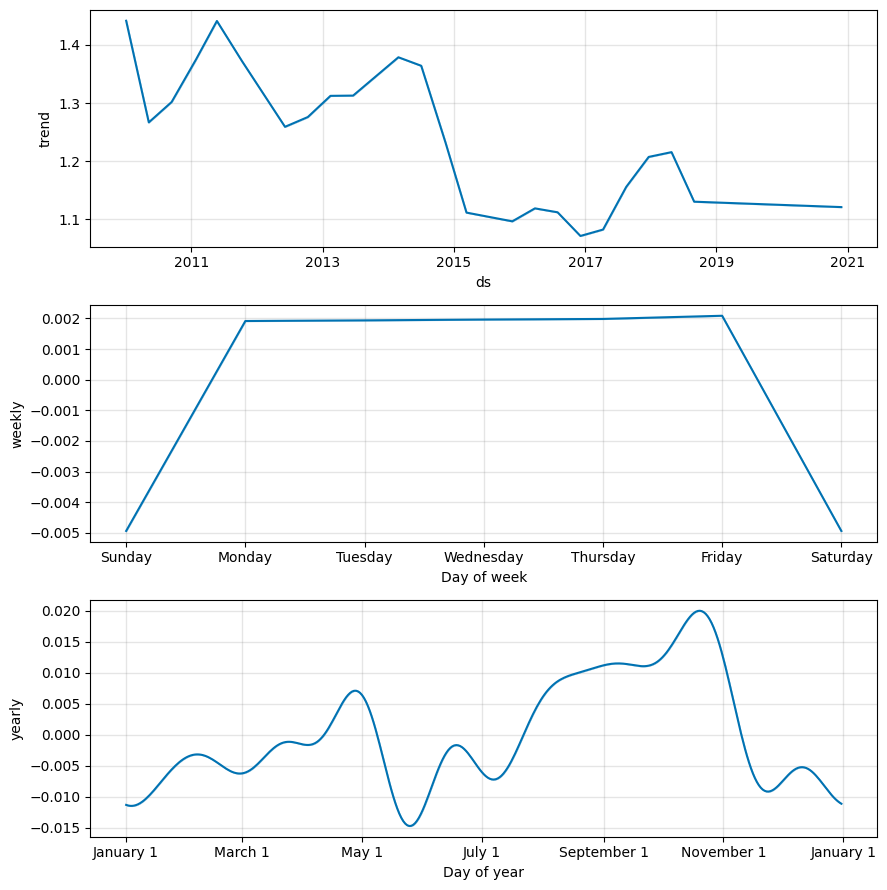

In [64]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

In [65]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Short long story: work hard for nothing

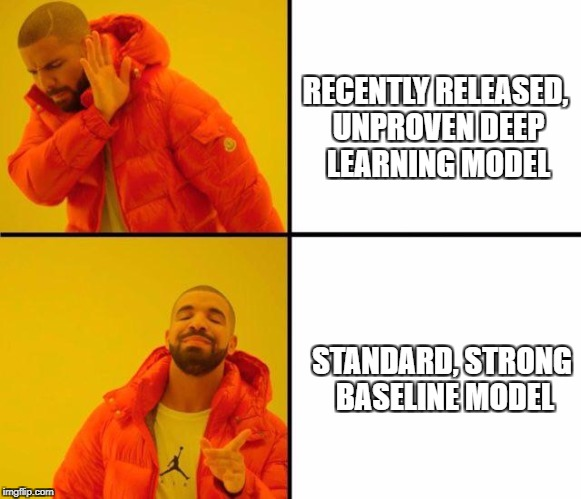

Let's have a look if "stupid" model is able to make better prediction than our method. We are going to shift the value of EURUSD change and use the value of 7 days ago to predict the value of EURUSD for tomorrow

In [66]:
final_df_results


,eurusd_close,yhat
2020-11-02,1.164212,1.133779
2020-11-03,1.164280,1.132473
2020-11-04,1.176221,1.131134
2020-11-05,1.173268,1.129762
2020-11-06,1.181754,1.128462
2020-11-09,1.189301,1.124149
2020-11-10,1.182732,1.122858
2020-11-11,1.181879,1.121629
2020-11-12,1.178030,1.120461
2020-11-13,1.180339,1.119455


In [67]:
final_df_results['yhat_baselinemodel'] = final_df_results['eurusd_close'].rolling(7).mean()

Mean MAE: 0.07
MAE%: 5.63%
RMSE: 0.07
Bias: -0.07

5th percetile MAE: 0.06
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.07


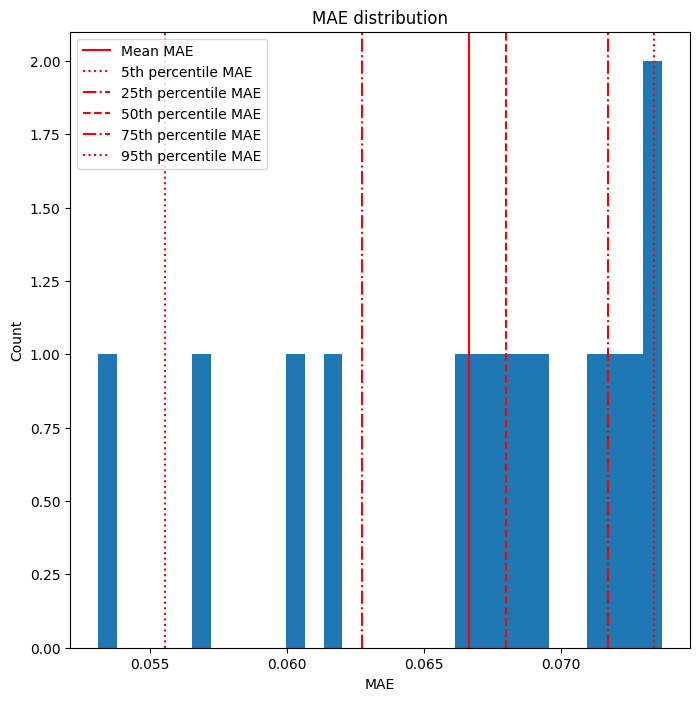

In [68]:
# Analyze the forecast error
calc_errors(final_df_results.dropna()['yhat_baselinemodel'].values, final_df_results.dropna()['yhat'].values)


## Improve forecasting perfomances : hyperparameter tuning and extra regressors

### Load useful data

What's the influence of external forces on FOREX?

We have dowload different timeseries that could have influenced the FOREX. It's clear that the use of these regressors to improve the forecasting performances increases the complexity of the model.

i.e. Let's say that we would like to forecast FOREX in the horizon May 2021 - Jan 2022. The values of extra regressor should be known, which means that other ML models should be use to forecast for example US GDP

Here we studied the effect of GDP, inflation and consumer price index on FOREX. Raw data where download from https://fred.stlouisfed.org/

### What about COVID-19?

Is the global vaccination race the new force in FX markets? – Special Report

https://www.xm.com/is-the-global-vaccination-race-the-new-force-in-fx-markets-special-report-135646

2020 and 2021 have been affected by COVID-19 pandemic. We all know the effect of the pandemic on daily life and economics. Starting from the first days of 2021, vaccinations and growth perspective have influenced a slow restart of "normal" life and therefore of economy.

Here we explore the effect of covid and vaccinations on FOREX. Data were download from https://github.com/owid/covid-19-data

In [69]:
# To load data from your google drive

#from google.colab import drive
#drive.mount('/content/drive')

Change the directory below using the one you have loaded the data in

In [70]:
#%cd /content/drive/MyDrive/Colab Notebooks/colab text data for trading/2024_course

In [160]:
df_covid = pd.read_csv('./owid-covid-data.csv', parse_dates=['date'], index_col='date')
extra_df = pd.read_csv('./extra_regressors.csv', parse_dates=['DATE'])

In [161]:
df_covid

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,1.0,1.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2020-02-25,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2020-02-26,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2020-02-27,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2020-02-28,AFG,Asia,Afghanistan,1.0,0.0,NaN,NaN,NaN,NaN,0.026,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-16,ZWE,Africa,Zimbabwe,38560.0,6.0,20.143,1582.0,0.0,0.857,2594.375,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
2021-05-17,ZWE,Africa,Zimbabwe,38572.0,12.0,19.857,1582.0,0.0,0.857,2595.182,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571
2021-05-18,ZWE,Africa,Zimbabwe,38595.0,23.0,21.000,1583.0,1.0,0.571,2596.729,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571


In [73]:
extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})


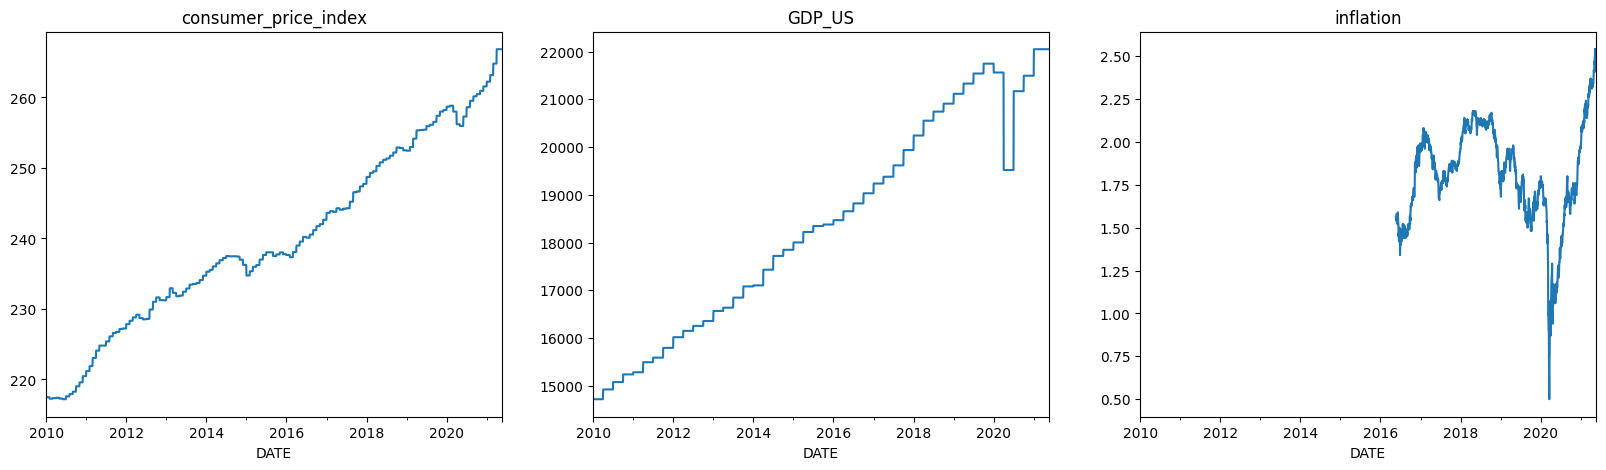

In [74]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

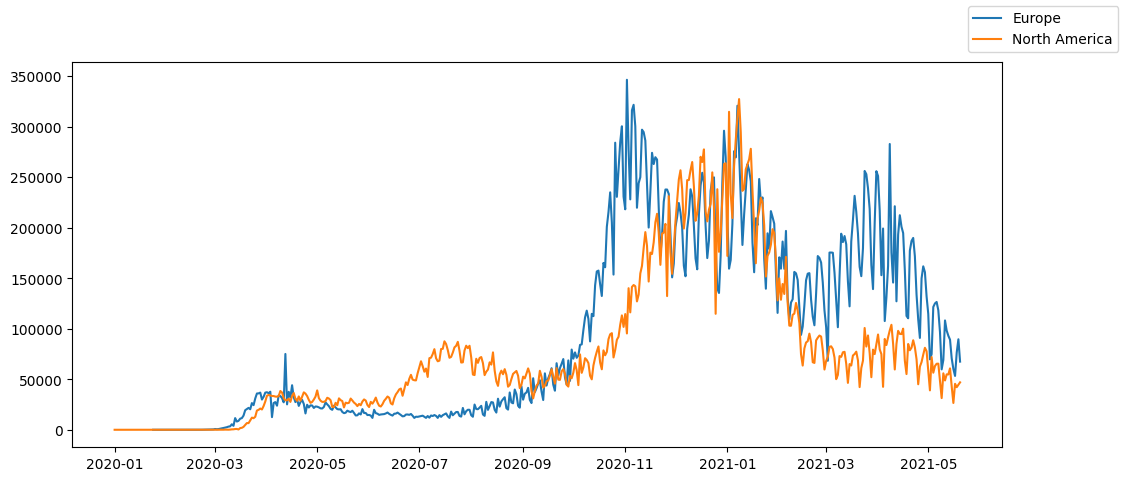

In [75]:
# compare Europe and North America time series
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_covid_g.loc['Europe'], label='Europe')
ax.plot(df_covid_g.loc['North America'], label='North America')
fig.legend()

### Timeseries correlation

# TASK 1: merge EURUSD data with external regressors and evaluate correlation.
Since you cannot use unavailable data for your prediction, shift all external regressor by two weeks so that you are sure you have all data available

### Forecasting using extra regressors with Prophet

# TASK 2: create a new model that exploits external regressors.
* Use function addregressor() to add your regressors and train a new model.
* Explore the usage of from prophet.diagnostics import cross_validation function.
* Create a cross validation experiment with cutoffs of the last 30 steps with initial='1119 days', period='1 days', horizon = '5 days'.
* test on the test dataset as before and evaluate performance metrics

In [204]:
# Define ds and y
df_final['ds'] = df_final.index
df_final['y'] = df_final['eurusd_close'].values

# Create training and test sets
train_indices =  ['2020-02-10','2021-02-04']
test_indices =  ['2021-02-05','2021-05-06']

#train = df_final[train_indices[0]:train_indices[1]]
#test = df_final[test_indices[0]:test_indices[1]]

#train

df_final.loc['2021-02-04']

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,CPIAUCSL,GDP,T10YIE,ds,y
date,,,,,,,,,,,,,,,,,,,,,
2021-02-04,AFG,Asia,Afghanistan,55557.0,17.0,19.571,2430.0,2.0,1.571,1427.161,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,OWID_AFR,NaN,Africa,3799304.0,13893.0,11613.000,100325.0,511.0,437.143,2834.037,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,ALB,Europe,Albania,96838.0,1112.0,1008.857,1617.0,17.0,14.286,33650.010,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,DZA,Africa,Algeria,111418.0,171.0,195.571,2950.0,3.0,2.857,2540.829,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,AND,Europe,Andorra,10610.0,27.0,31.286,107.0,0.0,0.143,137319.614,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,AGO,Africa,Angola,20452.0,52.0,27.286,498.0,2.0,1.571,622.279,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,AIA,North America,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,ATG,North America,Antigua and Barbuda,548.0,23.0,23.857,10.0,0.0,0.143,5595.948,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214
2021-02-04,ARG,South America,Argentina,2046795.0,7671.0,5492.857,50857.0,241.0,140.429,45287.306,...,0.9051,105.282997,127.919998,1.25926,0.790883,263.161,22048.894,2.17,2021-02-04,1.215214


# TASK 3: Can you think at other useful external regressors?
Find new data, add them and test their efficacy